# **Data Story Telling - Otto Group product classification**

After cleaning and doing the needed transformation in the Data Wrangling phase, let us now try to see what story our data tells. What interesting questions can we ask. Our final goal is to classify the products into one of the 9 product categories. So we should see the different features and which of them can be most significant or relevant for our purpose.

[Load the cleaned daat from previous work (ipynb)](#section1)

[Do we have same amount of data for all product categories?](#section2)

[What does the feature data look like?](#section3)

[How are the features related to each other?](#section4)

[How about more visulizations to understand the data better?](#section5)


<a id='section1'></a>

In [23]:
# pandas gives high-performance, easy-to-use data structures and data analysis tools
import pandas as pd

# fundamental package for scientific computing
import numpy as np 

# matplotlib provides a MATLAB-like plotting framework
import matplotlib.pyplot as plt
import matplotlib

# seaborn is visualization library based on matplotlib, 
# provides high level interface for drawing attractive statistical graphics
import seaborn as sns
sns.set_style(style='whitegrid')

In [24]:
# training data set
df = pd.read_csv("../data/train_cleaned.csv")

# test data set
df_test = pd.read_csv("../data/test_cleaned.csv")

<a id='section2'></a>

### Do we have same amount of data for all product categories?

It is often necessary to find out if we have same amount of data for all the classes that we are going to predict. If that is not the case, it is called **Class Imbalance**. That could affect our prediction efficiency. For example for a binary classification if the 99% data is from one class 'A' and the prediction algo has a very simple logic of predicting class 'A' always, still it would be accurate 99% of the times. Obviously its of no value.

So it is important to handle to first check class imbalance and then handle it appropriately. Let us visualize how much data we have for different classes.

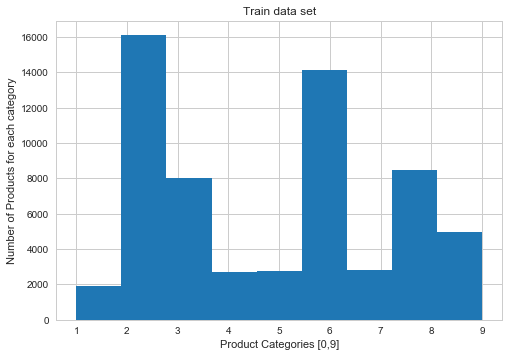

In [25]:
# counts for each target value
fig,ax0 = plt.subplots()
ax0.hist(df.target,bins=9)
ax0.set_title("Train data set")
ax0.set_ylabel("Number of Products for each category")
ax0.set_xlabel("Product Categories [0,9]")

plt.show()

Looks like **there is some class imbalance**. Class 2 and 6 seems to relatively very large from other classes. May be these are more general product categories. Later on we should deal with this class imbalance.

In [26]:
# numeric counts
from collections import Counter
Counter(df.target)

Counter({1: 1929,
         2: 16122,
         3: 8004,
         4: 2691,
         5: 2739,
         6: 14135,
         7: 2839,
         8: 8464,
         9: 4955})

<a id='section3'></a>

### What does the feature data look like?

Let us explore how the features data look like. Are the values spread a lot. Does different features have data in the same range. How much the data is spread? The following char answers some of the questions. Plot on the left has feature values on the x-axis and the counts of those x-values on the y-axis, but we since the counts are not evenly spread, we are plotting log of counts. On the right is zoomed in version excluding the rare x-values.

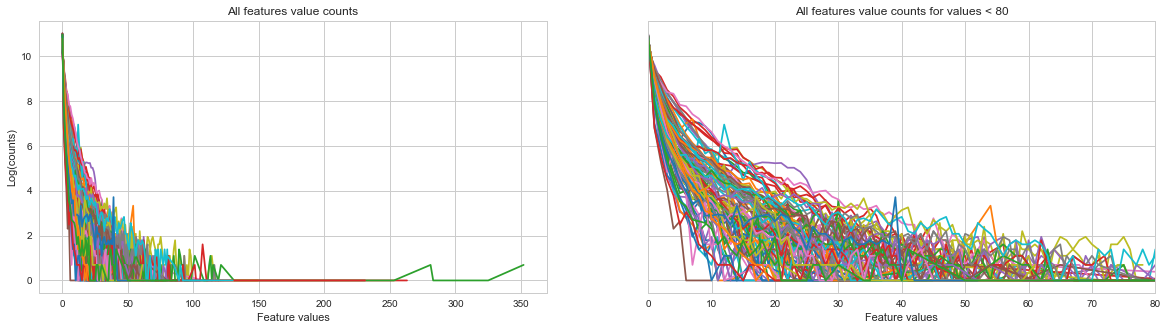

In [27]:
# here we can see extreme values for the features data
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(20,5)
num_of_features = 93

for i in  np.arange(1,num_of_features+1,1):
    data = df['feat_' + str(i)].value_counts()
    data.sort_index(inplace=True)
    ax1.set_ylabel("Log(counts)")
    ax1.set_xlabel("Feature values")
    ax1.set_title("All features value counts")
    ax1.plot(data.index,np.log(data.values))
    
    # looks like fewer values greater than 80 so zooming on other data
    data_reduced = data[0:80]
    ax2.set_title("All features value counts for values < 80")
    ax2.set_xlim(0,80)
    ax2.set_xlabel("Feature values")
    ax2.plot(data_reduced.index,np.log(data_reduced.values))
    
plt.show()

Another look at individual data points for all the features. 
- The gaps between the dots is showing that the feature values are integers.
- The color intesity shows how frequent is that feature value. 
- For most of the features most of the values are less than 20.
- We might not have to do the data normalization as all our feature data is at the same scale and range.

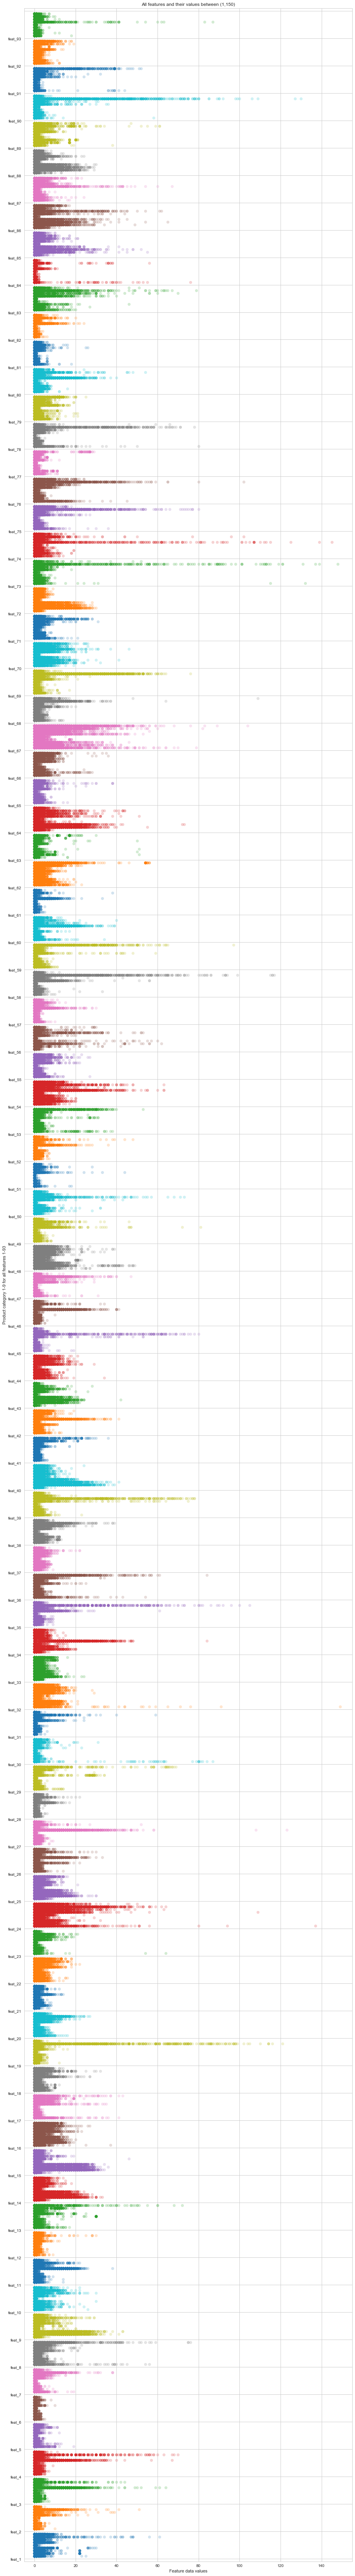

In [38]:
# check indivual values for each feature
fig,ax = plt.subplots()
fig.set_size_inches(15,120)
for i in  np.arange(1,num_of_features+1,1):
    df['target_new'] = df['target']+10*i
    ax.scatter(df['feat_' + str(i)], df.target_new,alpha=0.2)

ax.set_yticks(np.arange(10, 950, step=10))
ax.set_ylabel("Product category 1-9 for all features 1-93")
ax.set_xlabel("Feature data values")
labels = ["feat_"+str(i) for i in np.arange(1,94)]
ax.set_yticklabels(labels)
ax.set_ylim(9,941)
ax.set_xlim(-5,155)
ax.margins(0.05)
ax.set_title("All features and their values between (1,150)")

plt.show()

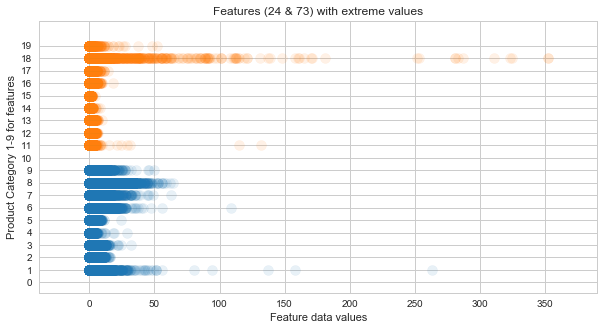

In [30]:
# following 2 features have relatively extreme values
plt.figure(figsize=(10,5))
plt.scatter(df['feat_24'], df.target,alpha=0.1,s=100)
plt.scatter(df['feat_73'], df.target+10,alpha=0.1,s=100)
plt.yticks(np.arange(0,20,1))
plt.ylabel("Product Category 1-9 for features")
plt.xlabel("Feature data values")
plt.title("Features (24 & 73) with extreme values")
plt.margins(0.1)
plt.show()

<a id='section4'></a>

### How are features related to each other?

Its important to find out relation between features if any. If 2 features are highly correlated than we can eliminate one to simplify our model and make better predictions.

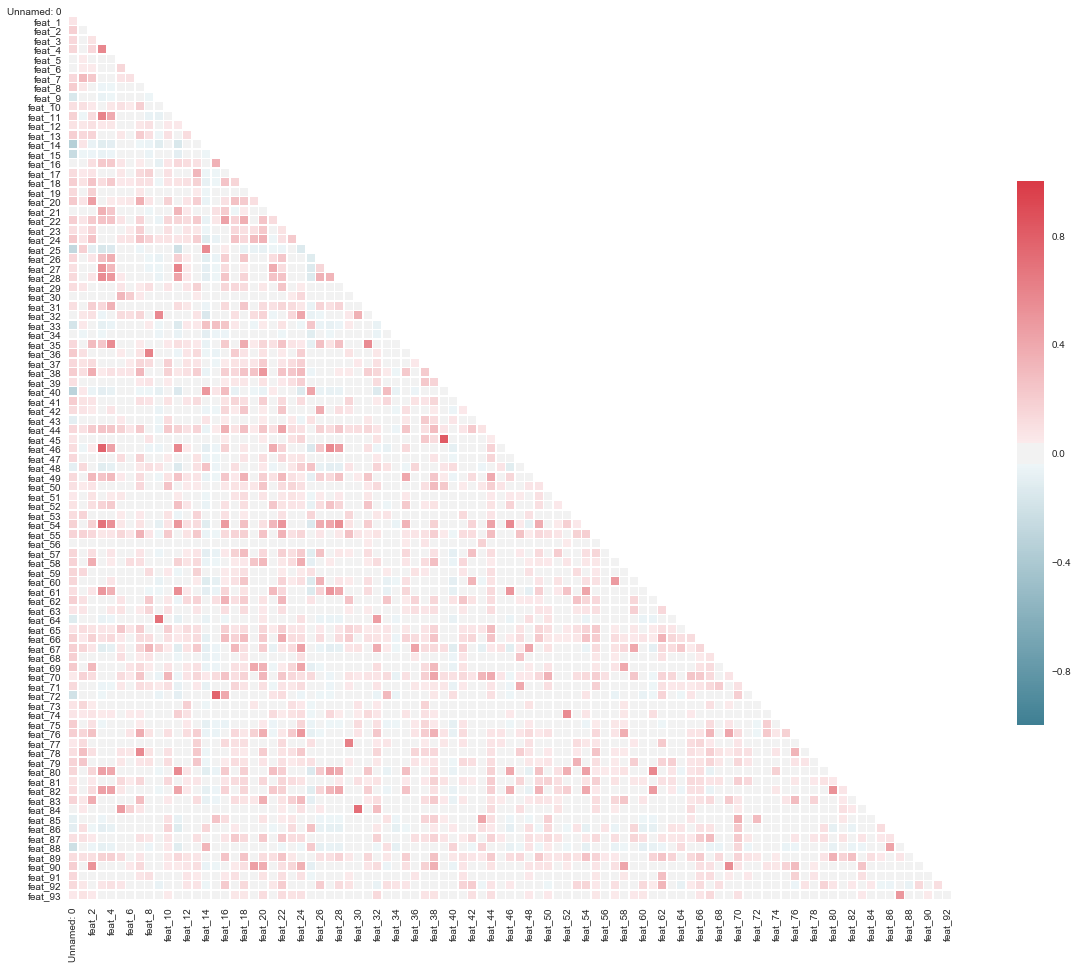

In [31]:
data = df[df.columns[0:94]]
correlations = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Let us see which of the features have good correlation (pearson's correlation index > 0.6)

In [32]:
list = [[(id+1, row_id+1) \
            for id,x in enumerate(row) \
                if ((x>0.6) | (x<-0.6)) & (id!=row_id)] \
                    for row_id, row in enumerate(correlations.values)]


list2 = [x for x in list if x!=[]]

import functools
list3 = functools.reduce(lambda x,y: x+y, list2)
high_correlated_features = [x for x in list3 if x[0]<x[1]]
print("Significantly correlated features: ", high_correlated_features)

Significantly correlated features:  [(9, 37), (40, 46), (4, 47), (4, 55), (10, 65), (16, 73), (30, 78), (31, 85)]


Let us visualize the correlations. It is quite obvious that feature 39 and 45 vary linearly with each other.

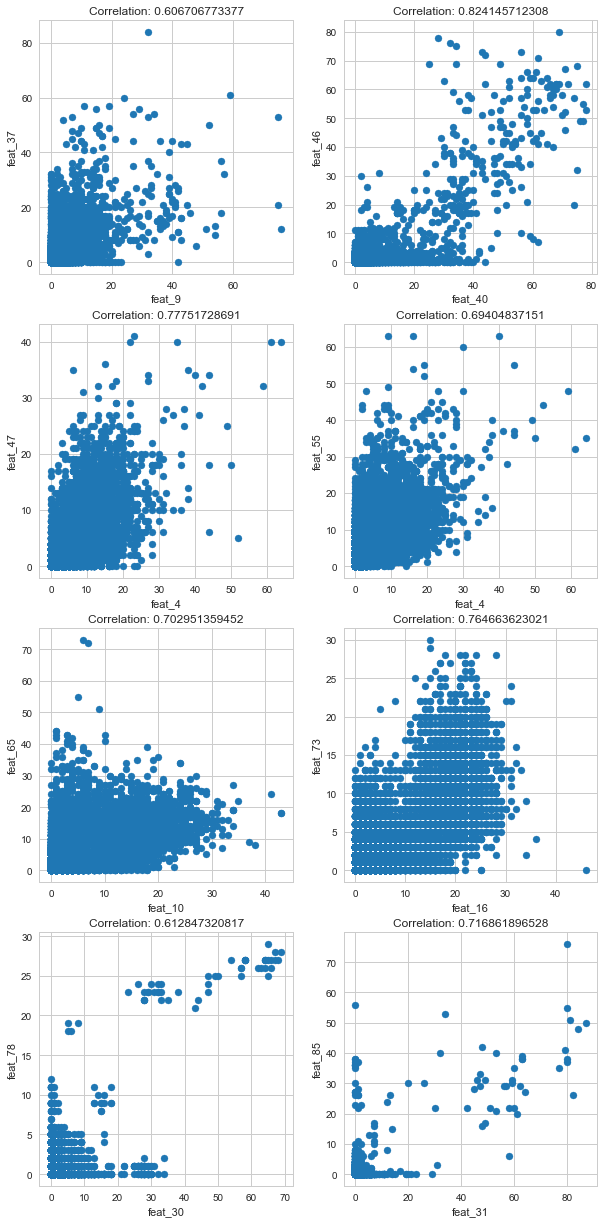

In [33]:
f, ax = plt.subplots(figsize=(10, 55))
i=1
for x,y in high_correlated_features:
    plt.subplot(10,2,i)
    i = i+1
    plt.scatter(df.iloc[:,x-1],df.iloc[:,y-1])
    plt.xlabel("feat_"+str(x))
    plt.ylabel("feat_"+str(y))
    plt.title("Correlation: " + str(correlations.iloc[x-1,y-1]))
plt.show()

<a id='section5'></a>

### How about more visulizations to understand the data better?

Let us visualize all the 60K row data in one scatter plot. We can see class imbalances and extreme data points at once. The width of the different color bands tell the relative amount of data for each class. Also most of the data points are less than 150.

In [34]:
%%script False
df2 = df
plt.figure(figsize=(20,20))
scat = plt.scatter(np.arange(0,len(df2.feat_1)),df2.feat_1,c=df2.target,cmap=plt.cm.cool)
cb = plt.colorbar(scat, spacing='proportional')

for col in df2.columns:
    plt.scatter(np.arange(0,len(df2[col])),df2[col],c=df2.target,cmap=plt.cm.cool)
plt.show()

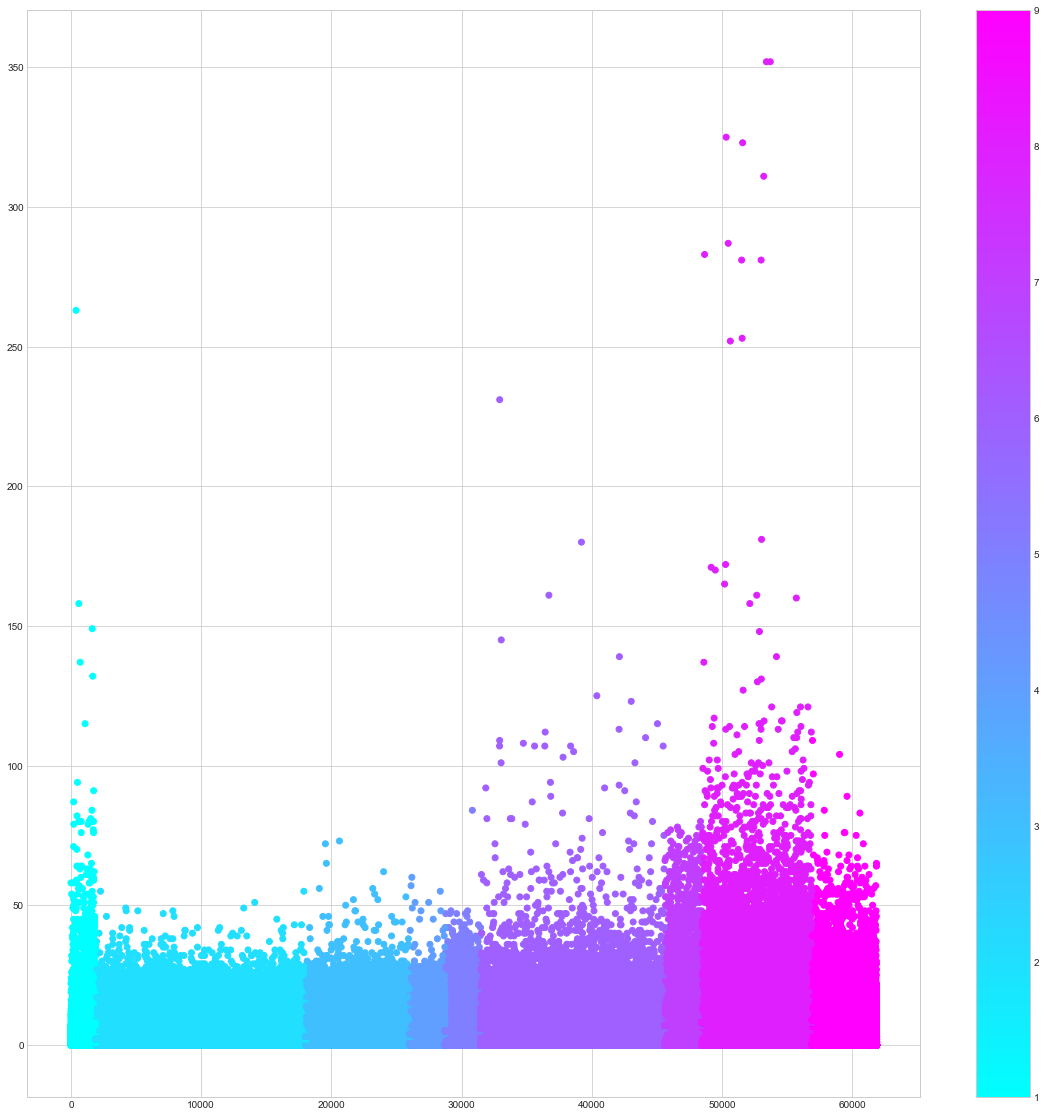

In [35]:
from IPython.display import Image, display
Image("scatter.png")

Let us see the data for individual category and within a particular category how the data varies for all the 93 features. As can be seen for most of the categories the data is centered at 0 except for few where we see another small peak around 1. For some classes data is tightly squeezed and for some it is little spread.

In [36]:
%%script False

for i in np.arange(1,10,1):
    cat_data_temp = df[df.target==i].drop("target",axis=1)
    plt.figure(figsize=(30,10))
    plt.xlim((-0.5,1.5))

    for col in cat_data_temp.columns:
         cat_data_temp[col].plot(kind="kde")

    plt.savefig("kde"+str(i)+".png")
    plt.show()
    

Data for category:  1


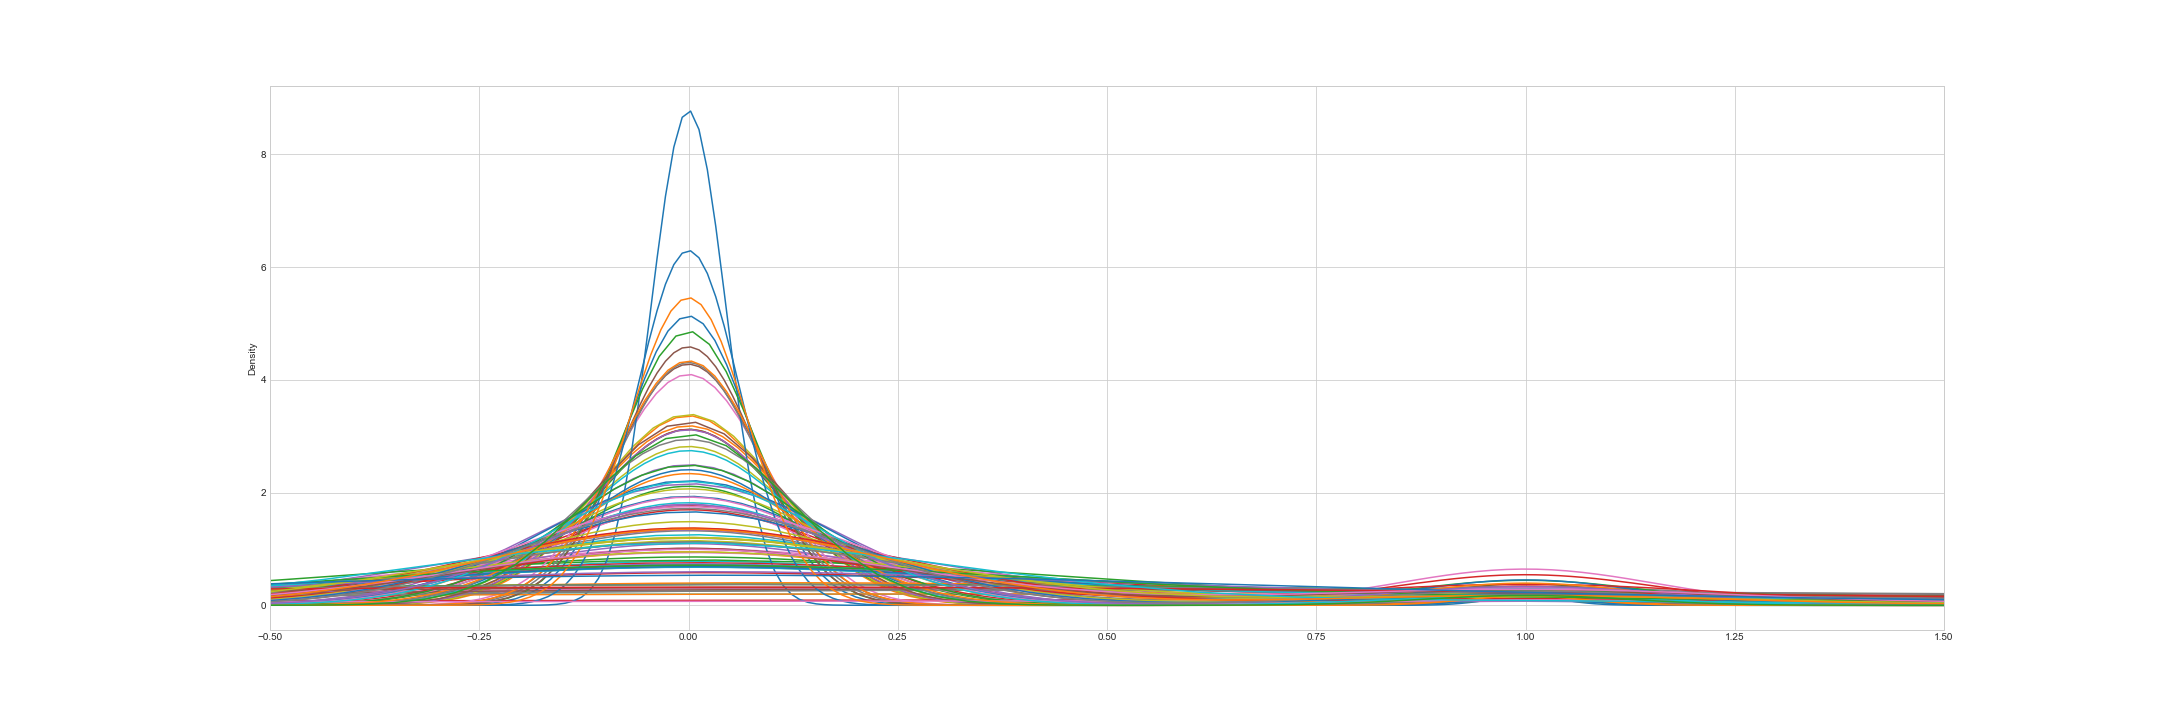

Data for category:  2


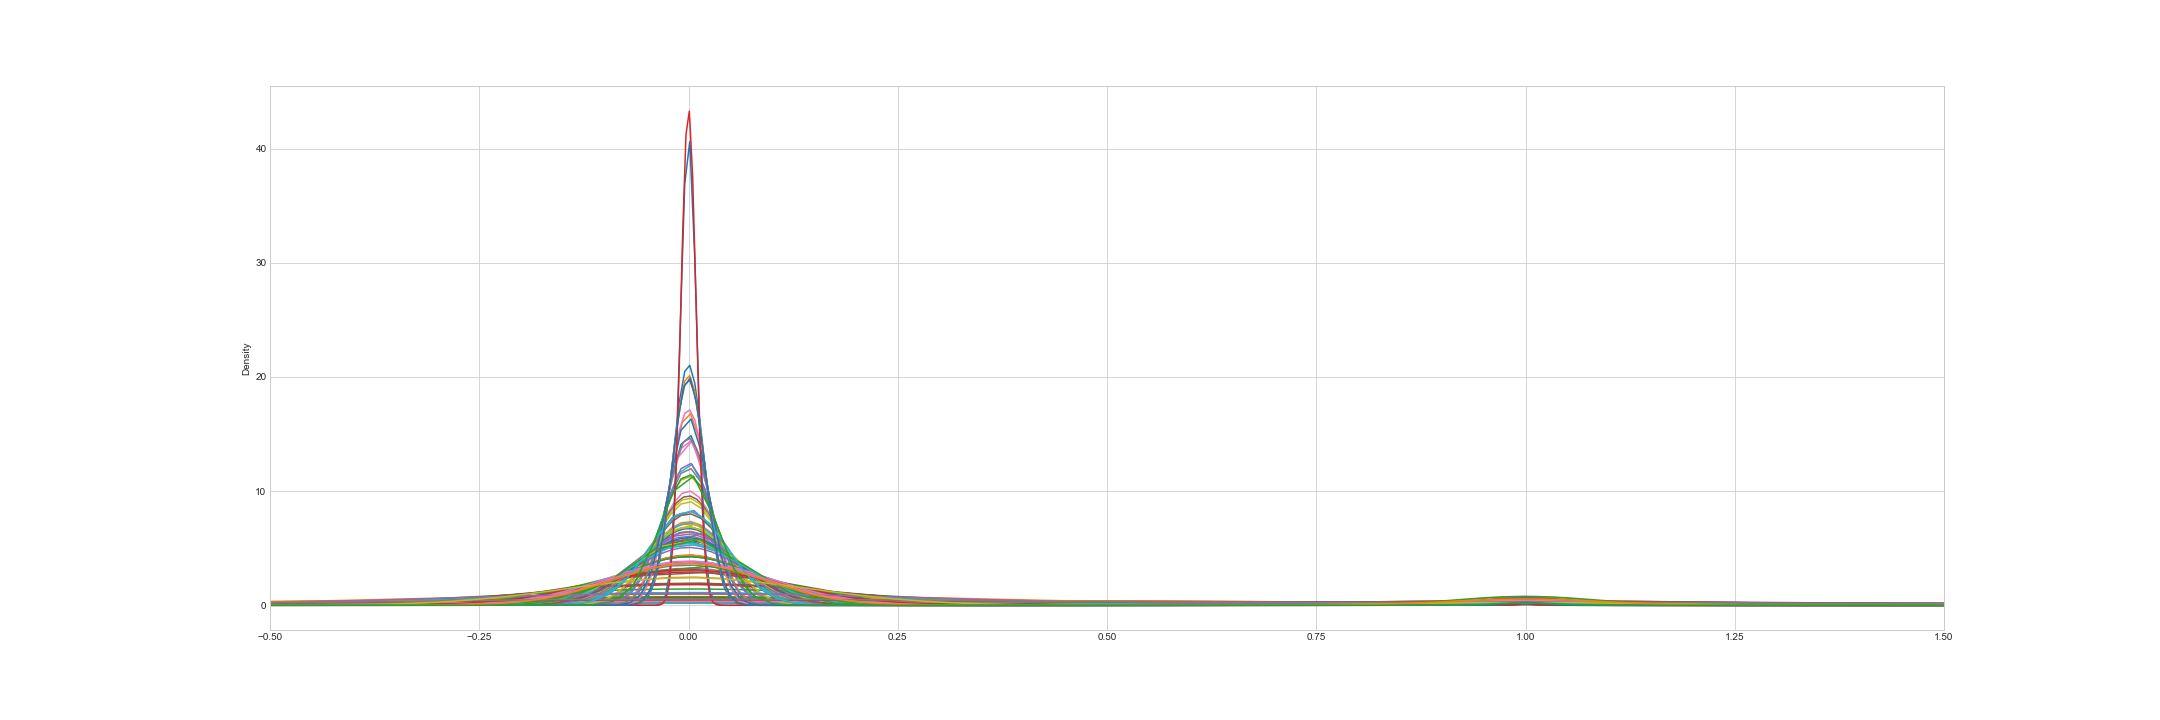

Data for category:  3


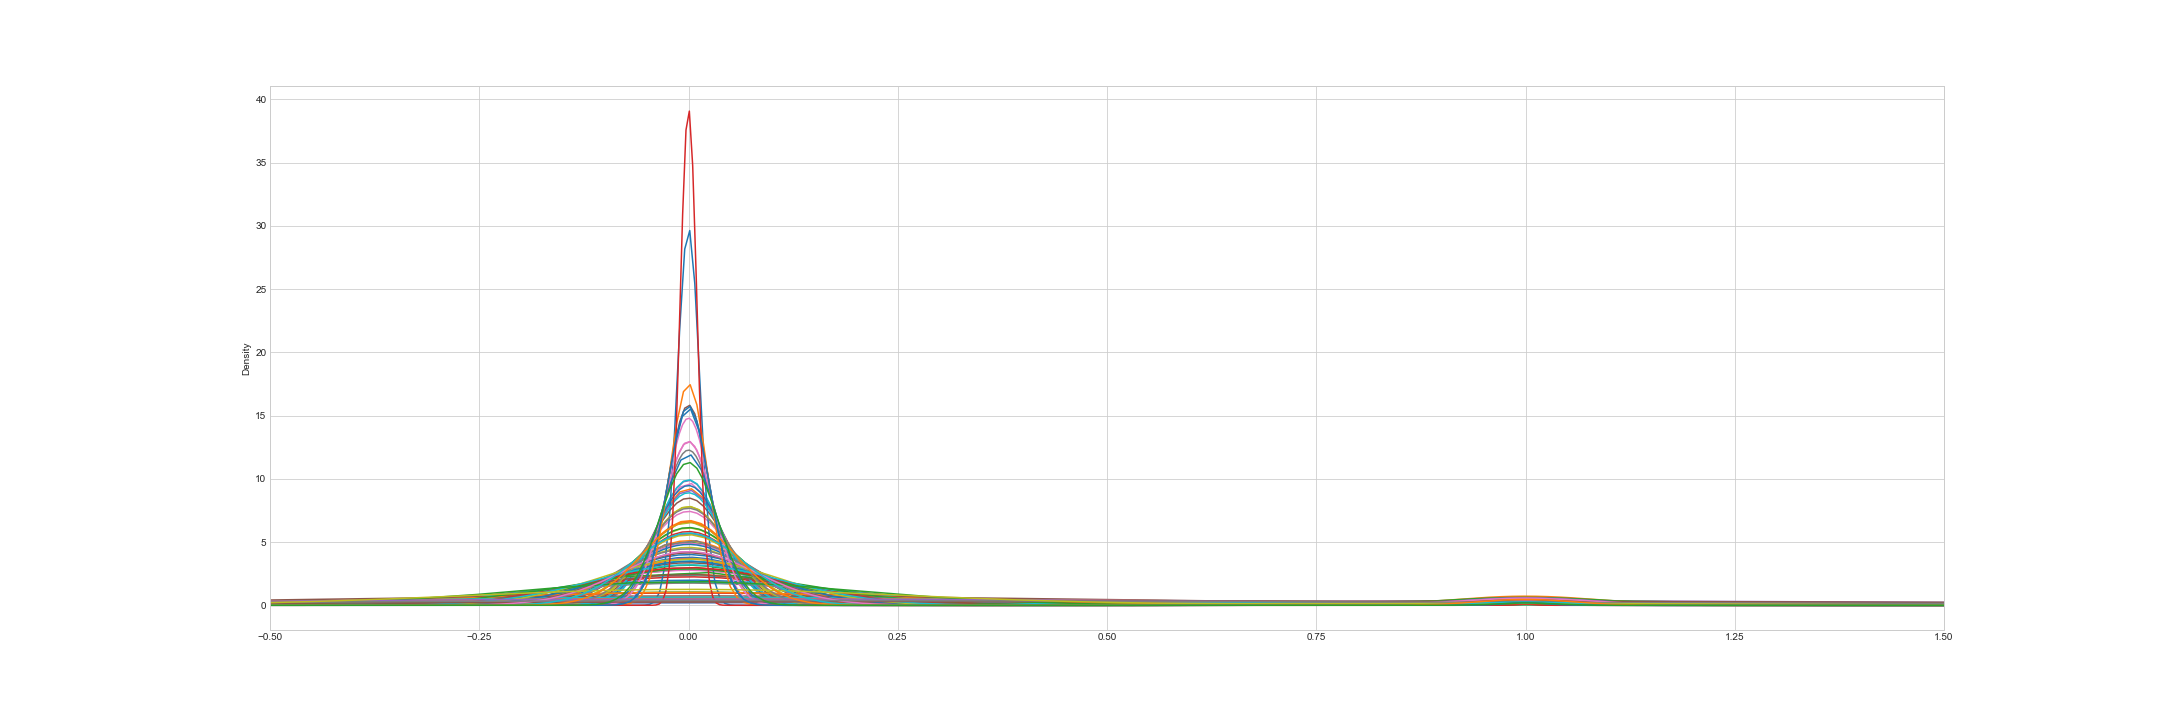

Data for category:  4


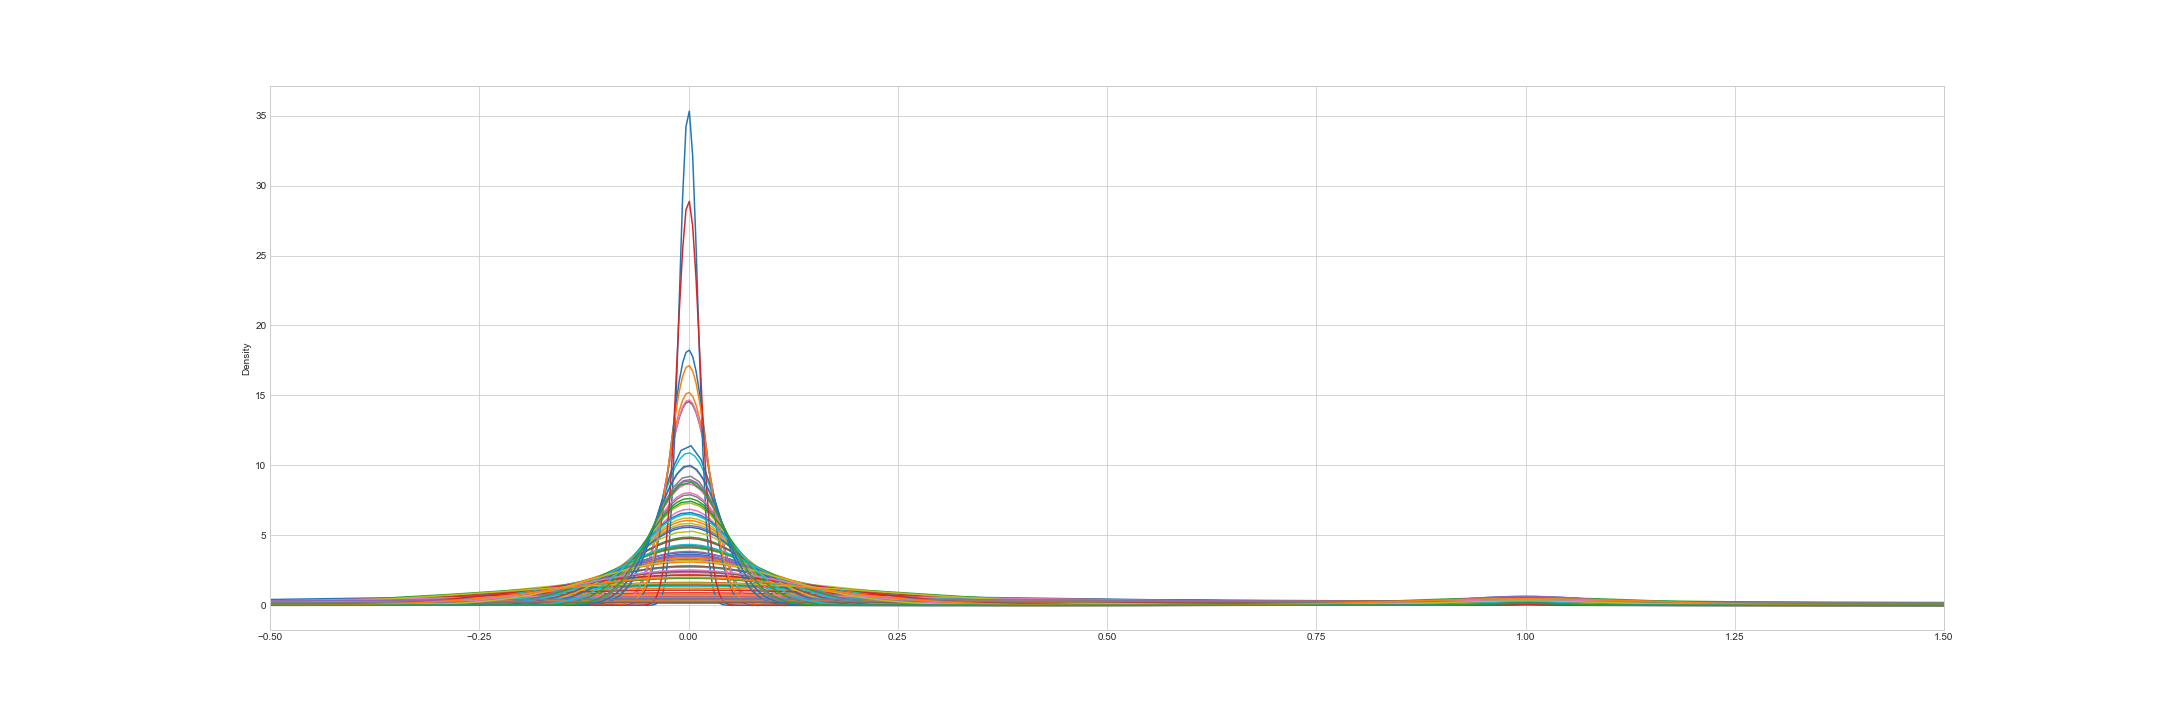

Data for category:  5


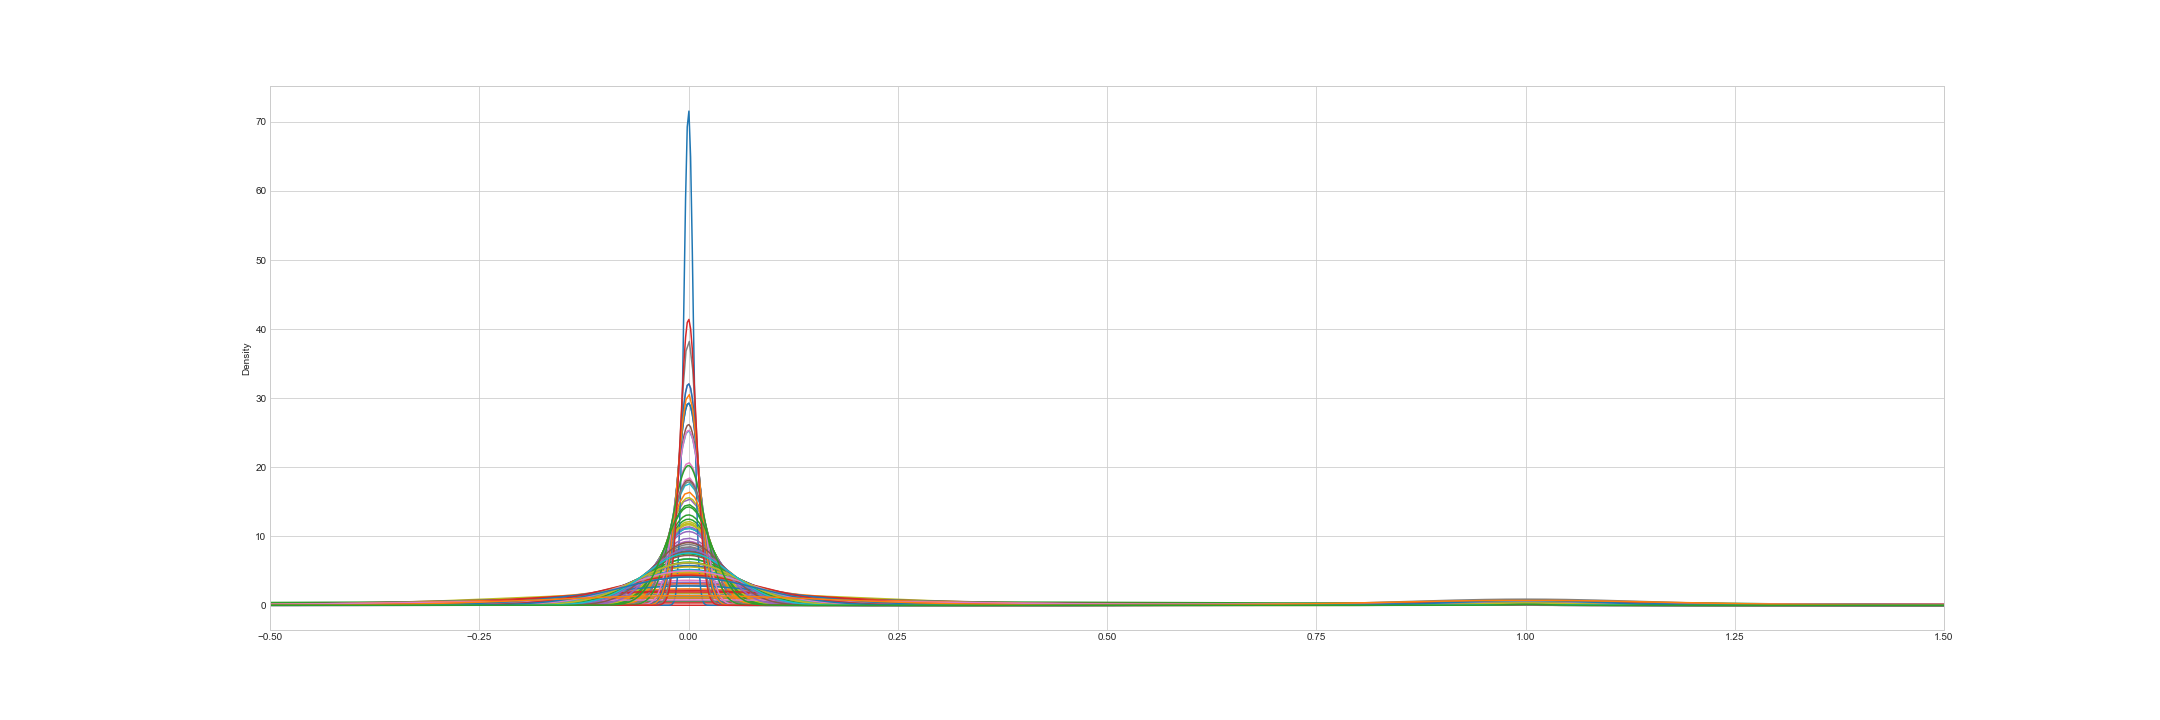

Data for category:  6


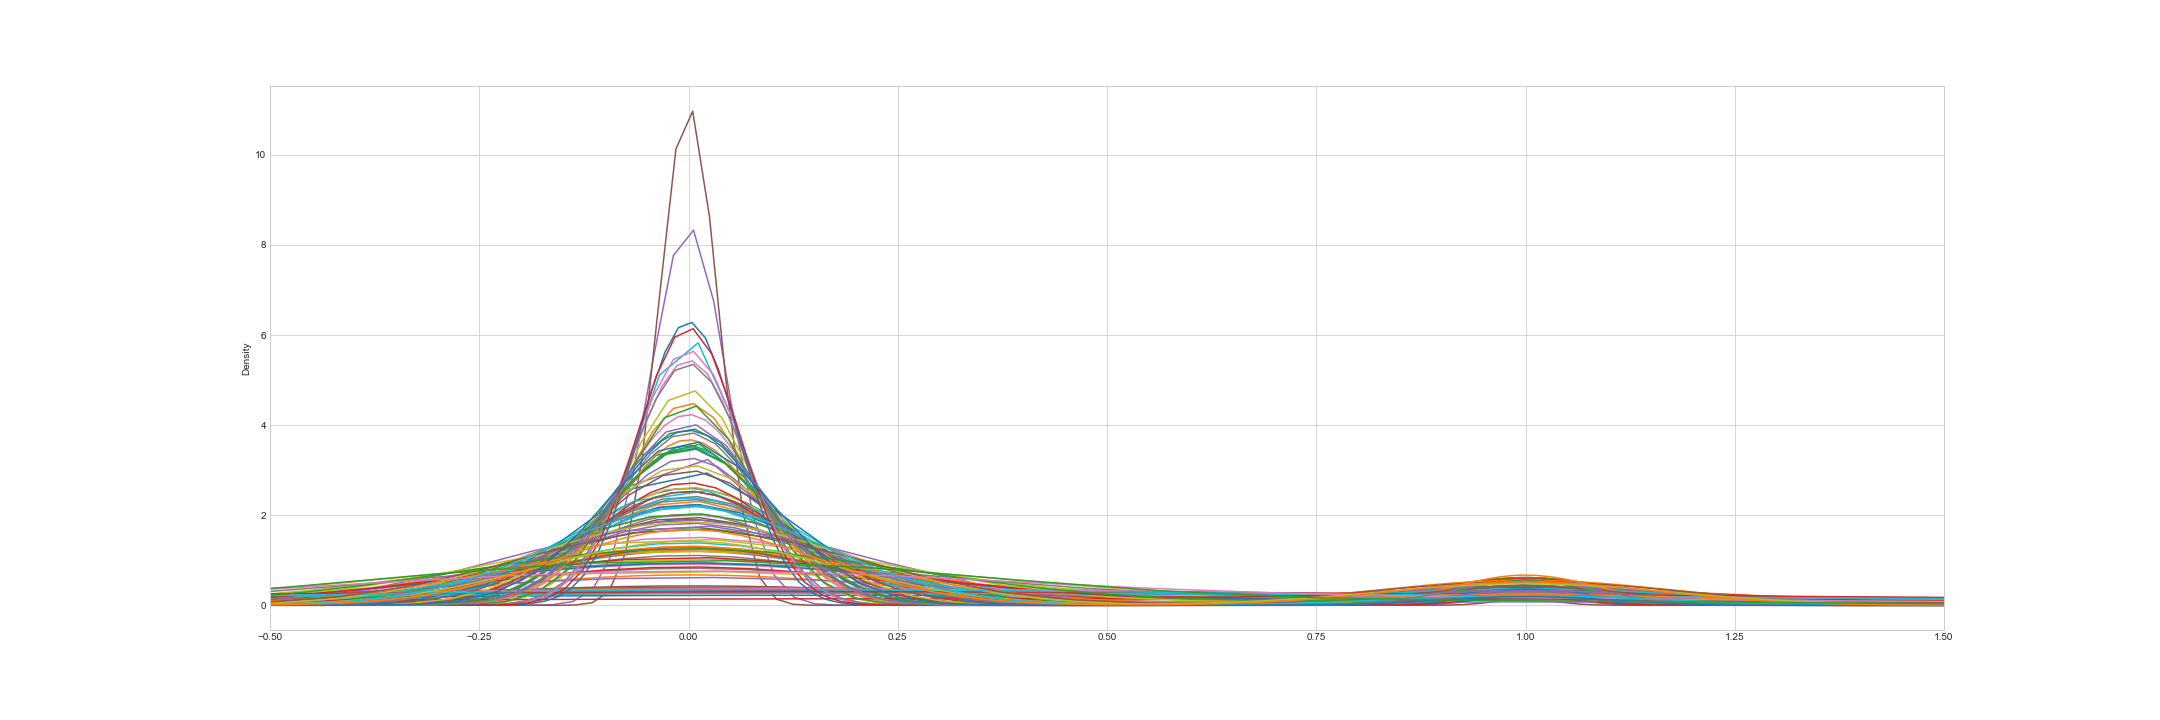

Data for category:  7


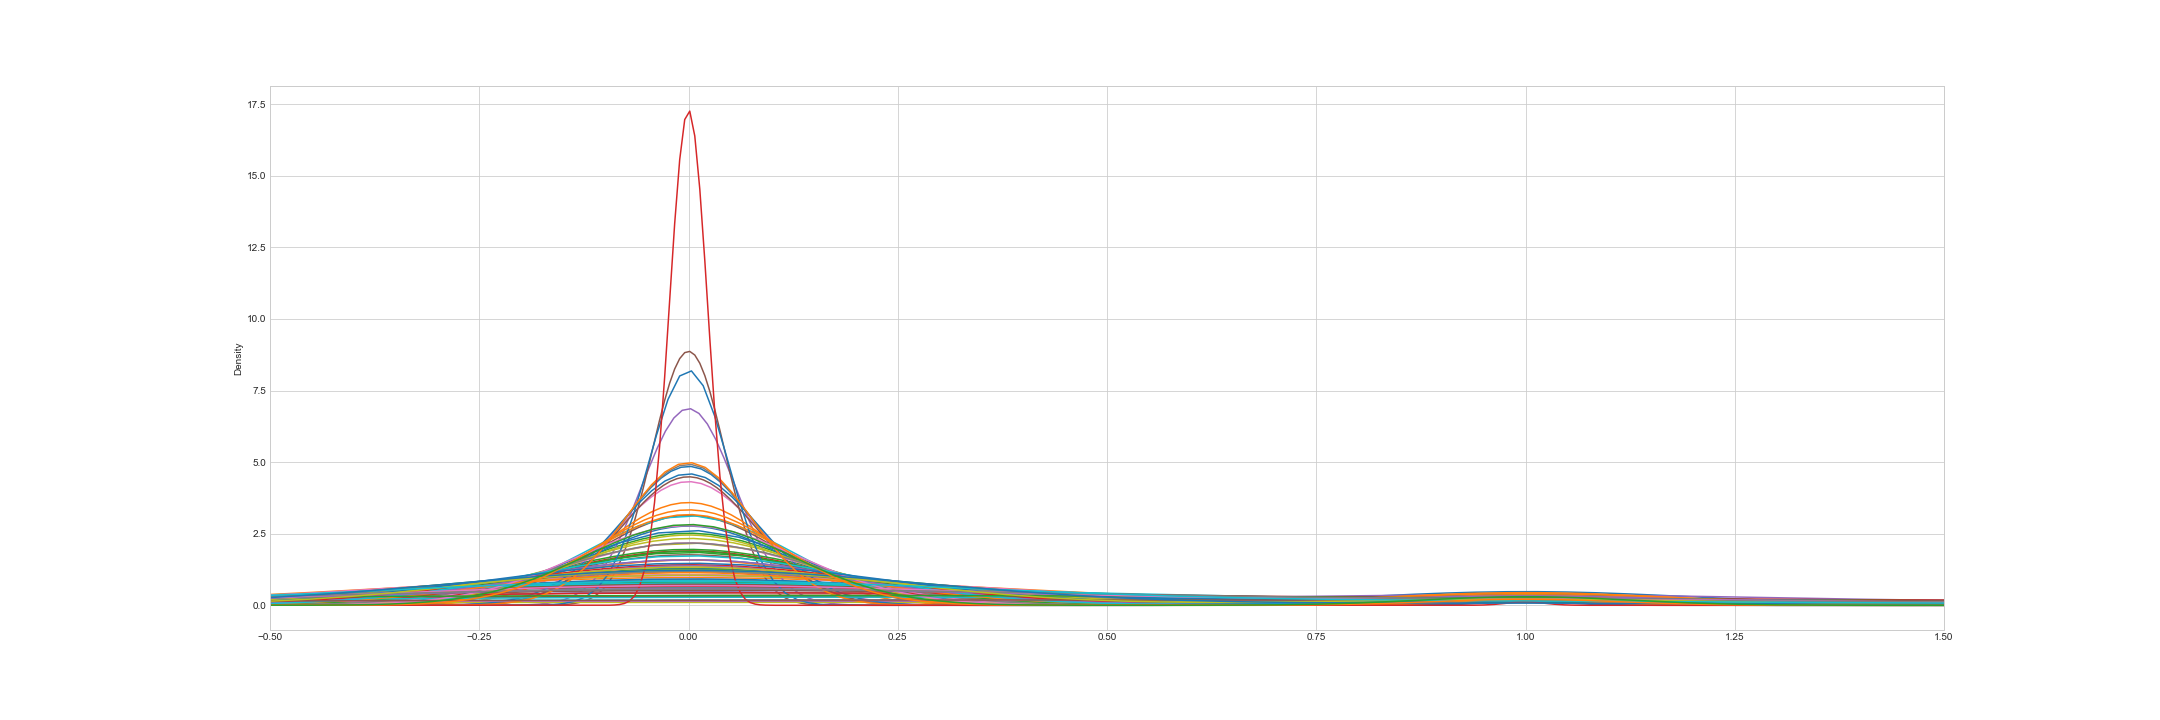

Data for category:  8


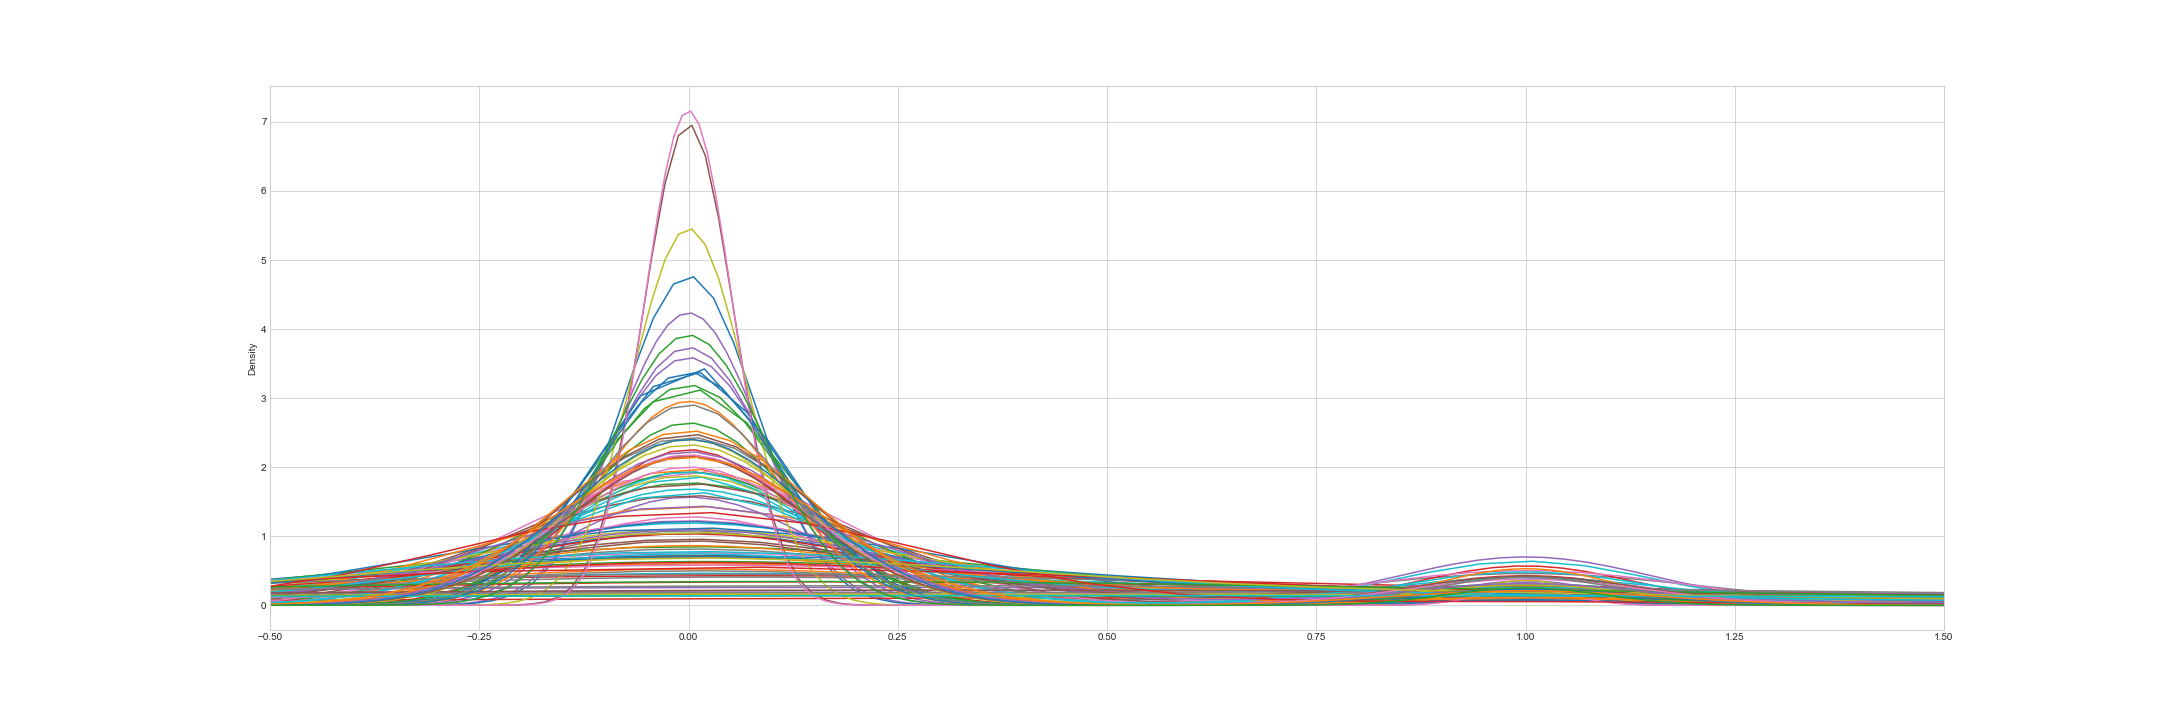

Data for category:  9


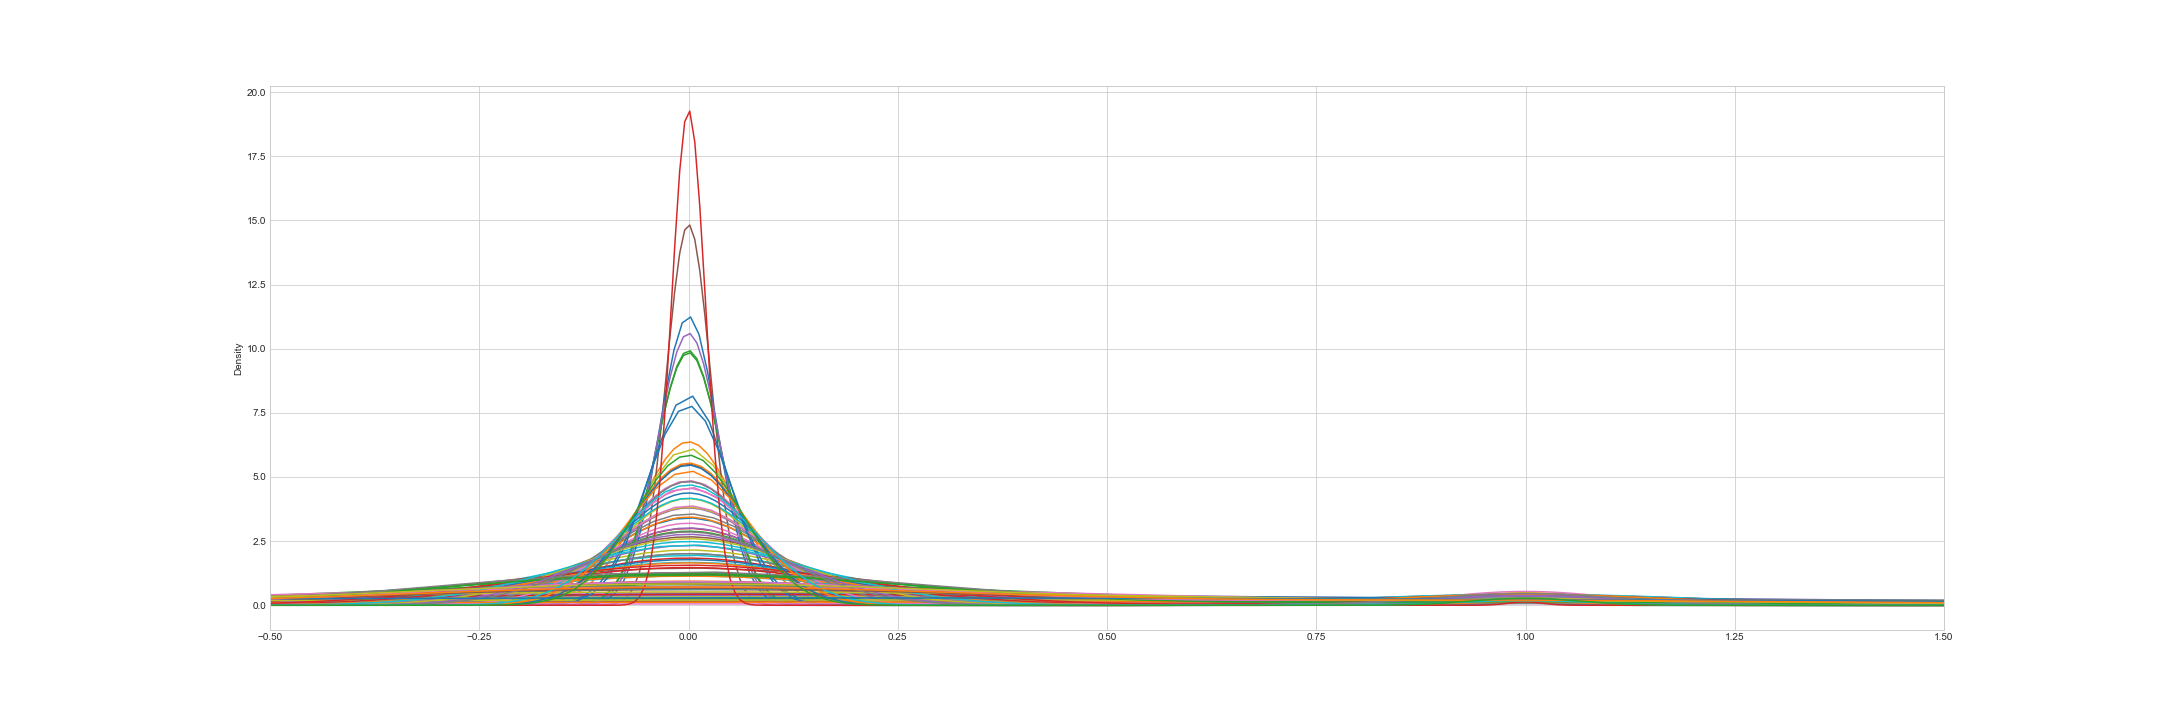

In [37]:
for i in np.arange(1,10,1):
    print("Data for category: ",i)
    display(Image("kde" + str(i) + ".png"))